# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
from tensorflow import keras
import random as rn
import tensorflow as tf

We set the random seed so that the results don't vary drastically.

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [2]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size =  16 #experiment with the batch size
total_train_size = len(train_doc)
total_val_size = len(val_doc)
print(total_train_size,total_val_size)

663 100


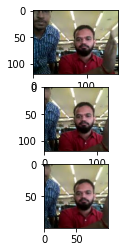

In [3]:
# Reading image of 160X120  to check the resized versin

import matplotlib.pyplot as plt
image = imread('/home/datasets/Project_data/train/WIN_20180925_17_30_21_Pro_Right_Swipe_new/WIN_20180925_17_30_21_Pro_00004.png')
h, w = image.shape[:-1]
if w == 160:
    image_1 = image[:120, 20:140]
resized_image = resize(image_1,(100, 100))
#plot_image([image,resized_image])
plt.figure(1)
plt.subplot(311)
plt.imshow(image)

plt.subplot(312)
plt.imshow(image_1)

plt.subplot(313)
plt.imshow(resized_image)

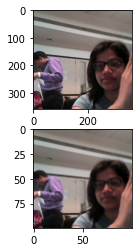

In [4]:
# Reading image of 360X360  to check the resized versin
image = imread('/home/datasets/Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00012.png')
resized_image = resize(image,(100, 100))
plt.figure(1)
plt.subplot(211)
plt.imshow(image)

plt.subplot(212)
plt.imshow(resized_image)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
def generator(source_path, folder_list, batch_size,total_frames=30,img_size=100,abilation = None):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0,29,total_frames)).astype(int)
    while True:
        if abilation is not None:
            folder_list = folder_list[:abilation]
        t = np.random.permutation(folder_list)
        total_num_data = len(t)
        num_batches =  (total_num_data//batch_size)  # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,total_frames,img_size,img_size,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w = image.shape[:-1]
                    if w == 160:
                        image = image[:120, 20:140]
                    image = resize(image, (img_size, img_size))
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels
        remaining_folders =  (total_num_data % batch_size)
        batch = num_batches
        if remaining_folders > 0:
            batch_data = np.zeros((remaining_folders,total_frames,img_size,img_size,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_folders,5)) # batch_labels is the one hot representation of the output
            for folder in range(remaining_folders): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    image = resize(image, (img_size, img_size))

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels 

In [7]:
# Plot the history of validation and training loss/accuracy across epochs
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

def buildModelConvo3D1(total_frames,img_size):
    model = Sequential()

    model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(total_frames,img_size,img_size,3)))
    model.add(MaxPooling3D(pool_size=(2, 2, 2),padding="same"))
    model.add(BatchNormalization())

    model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding="same"))
    model.add(MaxPooling3D(pool_size=(2, 2, 2),padding="same"))
    model.add(BatchNormalization())

    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding="same" ))
    model.add(MaxPooling3D(pool_size=(2, 2, 2),padding="same"))
    model.add(BatchNormalization())

    model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding="same" ))
    model.add(MaxPooling3D(pool_size=(2, 2, 2),padding="same"))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dense(5, activation='softmax'))
    return model

In [10]:
# Overfit training data on small datase
def fitWithAbilation(model,abilationsize,total_frames,img_size):
    optimiser = optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    abilation_training_size = abilationsize
    abilation_validation_size = abilationsize

    train_generator = generator(train_path, train_doc, abilation_training_size,total_frames,img_size,abilation_training_size)
    val_generator = generator(val_path, val_doc, abilation_validation_size,total_frames,img_size,abilation_validation_size)

    history = model.fit(train_generator, epochs=7,steps_per_epoch=1, validation_data=val_generator, validation_steps = 1)
    return history


In [24]:
def train_with_abilation(modelFn,total_frames,img_size,abilationsize=64):
    model = modelFn(total_frames,img_size)
    fitWithAbilation(model,abilationsize,total_frames,img_size)


In [68]:
train_with_abilation(buildModelConvo3D1,total_frames=5,img_size=120)

Source path =  /home/datasets/Project_data/train ; batch size = 64
Epoch 1/7
1/1 [==============================] - 6s 6s/step - loss: 2.1660 - categorical_accuracy: 0.2344 - val_loss: 8.9494 - val_categorical_accuracy: 0.2031
Epoch 2/7
1/1 [==============================] - 5s 5s/step - loss: 0.2105 - categorical_accuracy: 0.9062 - val_loss: 13.5445 - val_categorical_accuracy: 0.2031
Epoch 3/7
1/1 [==============================] - 6s 6s/step - loss: 0.0133 - categorical_accuracy: 1.0000 - val_loss: 16.0529 - val_categorical_accuracy: 0.2031
Epoch 4/7
1/1 [==============================] - 5s 5s/step - loss: 0.0083 - categorical_accuracy: 1.0000 - val_loss: 17.1394 - val_categorical_accuracy: 0.2031
Epoch 5/7
1/1 [==============================] - 6s 6s/step - loss: 0.0072 - categorical_accuracy: 1.0000 - val_loss: 17.3359 - val_categorical_accuracy: 0.2031
Epoch 6/7
1/1 [==============================] - 5s 5s/step - loss: 0.0065 - categorical_accuracy: 1.0000 - val_loss: 17.0044 - v

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [40]:
def fitModel(model,batch_size,total_frames,img_size,num_epochs,initial_lr=0.01,saveCheckPoint=False): 
    np.random.seed(30)
    rn.seed(30)
    tf.random.set_seed(30)
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    train_generator = generator(train_path, train_doc, batch_size,total_frames,img_size)
    val_generator = generator(val_path, val_doc, batch_size,total_frames,img_size)

    
    LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=3, min_lr=0.0001)
    if saveCheckPoint == True:
        curr_dt_time = datetime.datetime.now()
        model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',epoch = num_epochs)

        callbacks_list = [checkpoint,LR]
    else:
        callbacks_list = [LR]
    optimiser = optimizers.SGD(learning_rate=initial_lr)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())

    history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    return history

In [13]:
def train_model(modelFn,num_of_frames,img_size,batch_size,num_epoch,initial_lr=0.01,saveCheckPoint=False):
    model = modelFn(num_of_frames,img_size)
    history = fitModel(model,batch_size,num_of_frames,img_size,num_epoch,initial_lr,saveCheckPoint)
    plot(history)

In [41]:
train_model(buildModelConvo3D1,num_of_frames=5,img_size=100,batch_size=16,num_epoch=20,initial_lr=0.01,saveCheckPoint=True)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_20 (Conv3D)           (None, 3, 98, 98, 16)     1312      
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 2, 49, 49, 16)     0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 2, 49, 49, 16)     64        
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 2, 49, 49, 32)     13856     
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 1, 25, 25, 32)     0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 1, 25, 25, 32)     128       
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 1, 25, 25, 64)   

KeyboardInterrupt: 

In [15]:
# Add dropouts
def buildModelConvo3D2(total_frames,img_size):
    model = Sequential()

    model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(total_frames,img_size,img_size,3)))
    model.add(MaxPooling3D(pool_size=(2, 2, 2),padding="same"))
    model.add(BatchNormalization())

    model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding="same"))
    model.add(MaxPooling3D(pool_size=(2, 2, 2),padding="same"))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding="same" ))
    model.add(MaxPooling3D(pool_size=(2, 2, 2),padding="same"))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding="same" ))
    model.add(MaxPooling3D(pool_size=(2, 2, 2),padding="same"))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(5, activation='softmax'))
    return model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 3, 98, 98, 16)     1312      
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 2, 49, 49, 16)     0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 2, 49, 49, 16)     64        
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 2, 49, 49, 32)     13856     
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 1, 25, 25, 32)     0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 1, 25, 25, 32)     128       
_________________________________________________________________
dropout (Dropout)            (None, 1, 25, 25, 32)    

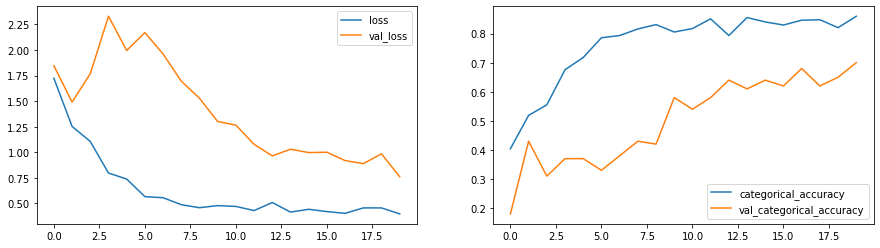

In [16]:
train_model(buildModelConvo3D2,num_of_frames=5,img_size=100,batch_size=16,num_epoch=20,initial_lr=0.01,saveCheckPoint=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 8, 98, 98, 16)     1312      
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 4, 49, 49, 16)     0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 4, 49, 49, 16)     64        
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 4, 49, 49, 32)     13856     
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 2, 25, 25, 32)     0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 2, 25, 25, 32)     128       
_________________________________________________________________
dropout_4 (Dropout)          (None, 2, 25, 25, 32)    

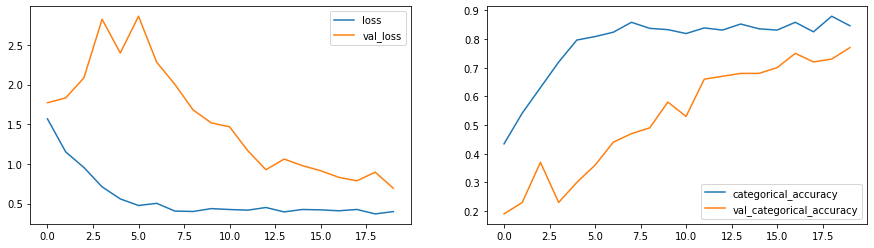

In [17]:
# Adding more image frame
train_model(buildModelConvo3D2,num_of_frames=10,img_size=100,batch_size=16,num_epoch=20,initial_lr=0.01,saveCheckPoint=True)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 8, 98, 98, 16)     1312      
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 4, 49, 49, 16)     0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 4, 49, 49, 16)     64        
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 4, 49, 49, 32)     13856     
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 2, 25, 25, 32)     0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 2, 25, 25, 32)     128       
_________________________________________________________________
dropout_12 (Dropout)         (None, 2, 25, 25, 32)    

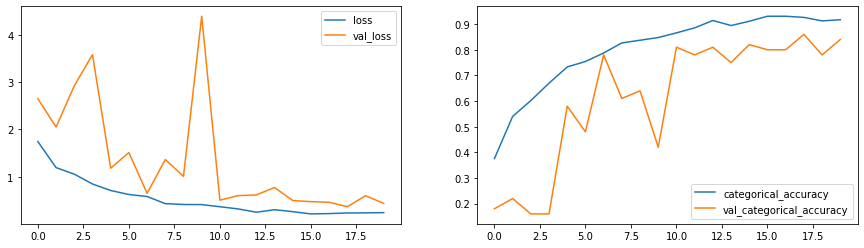

In [19]:
# Reduce the batch size to check if model generalises
train_model(buildModelConvo3D2,num_of_frames=10,img_size=100,batch_size=10,num_epoch=20,initial_lr=0.01,saveCheckPoint=True)

### Building model using CNN and RNN

In [20]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Flatten,Dense,TimeDistributed,GRU,Conv2D,MaxPooling2D

In [28]:
def buildModelCNNRNN1(total_frames,img_size):
    model = Sequential()
    mobilenet = MobileNet(include_top=False,weights='imagenet',input_shape=(img_size,img_size,3))
    model.add(TimeDistributed(mobilenet,input_shape=(total_frames,img_size,img_size,3)))
    for layer in model.layers:
        layer.trainable = False
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(GRU(64))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(5,activation='softmax'))
    return model

In [25]:
#Trying to check model overfits on small data set
train_with_abilation(buildModelCNNRNN_TL,total_frames=10,img_size=100,abilationsize=64)

Source path =  /home/datasets/Project_data/train ; batch size = 64
Epoch 1/7
1/1 [==============================] - 11s 11s/step - loss: 1.9250 - categorical_accuracy: 0.2188 - val_loss: 1.7392 - val_categorical_accuracy: 0.2188
Epoch 2/7
1/1 [==============================] - 10s 10s/step - loss: 1.3629 - categorical_accuracy: 0.4844 - val_loss: 1.7302 - val_categorical_accuracy: 0.2188
Epoch 3/7
1/1 [==============================] - 10s 10s/step - loss: 1.1476 - categorical_accuracy: 0.5625 - val_loss: 1.7217 - val_categorical_accuracy: 0.2344
Epoch 4/7
1/1 [==============================] - 11s 11s/step - loss: 0.8622 - categorical_accuracy: 0.7969 - val_loss: 1.6979 - val_categorical_accuracy: 0.2344
Epoch 5/7
1/1 [==============================] - 10s 10s/step - loss: 0.8126 - categorical_accuracy: 0.7656 - val_loss: 1.6639 - val_categorical_accuracy: 0.2969
Epoch 6/7
1/1 [==============================] - 10s 10s/step - loss: 0.6015 - categorical_accuracy: 0.9688 - val_loss: 1.6

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_8 (TimeDist (None, 10, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_9 (TimeDist (None, 10, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_10 (TimeDis (None, 10, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 10, 1024)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                209280    
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 5)                

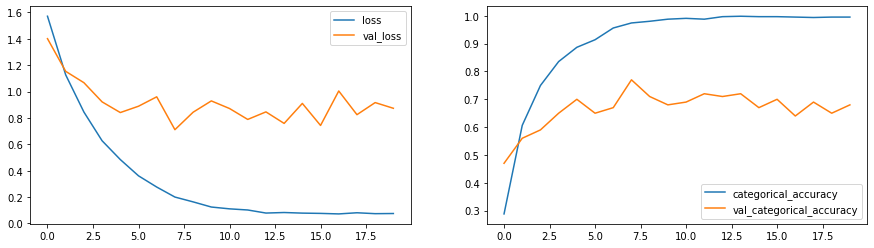

In [29]:
train_model(buildModelCNNRNN1,num_of_frames=10,img_size=100,batch_size=10,num_epoch=20,initial_lr=0.01,saveCheckPoint=True)

In [31]:
def buildModelCNNRNN2(total_frames,img_size):
    model = Sequential()
    mobilenet = MobileNet(include_top=False,weights='imagenet',input_shape=(img_size,img_size,3))
    model.add(TimeDistributed(mobilenet,input_shape=(total_frames,img_size,img_size,3)))
    
    for layer in model.layers:
        layer.trainable = False
    
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(GRU(64))
    model.add(Dropout(0.3))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(5,activation='softmax'))
    return model

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_12 (TimeDis (None, 10, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_13 (TimeDis (None, 10, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_14 (TimeDis (None, 10, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 10, 1024)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                209280    
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)               

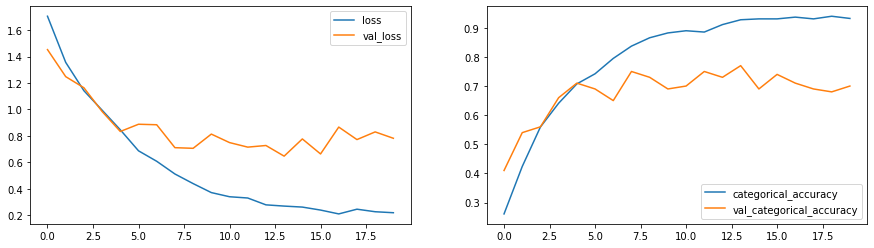

In [32]:
train_model(buildModelCNNRNN2,num_of_frames=10,img_size=100,batch_size=10,num_epoch=20,initial_lr=0.01,saveCheckPoint=True)

In [33]:
def buildModelCNNRNN3(total_frames,img_size):
    model = Sequential()
    mobilenet = MobileNet(include_top=False,weights='imagenet',input_shape=(img_size,img_size,3))
    model.add(TimeDistributed(mobilenet,input_shape=(total_frames,img_size,img_size,3)))
    
    for layer in model.layers:
        layer.trainable = False
    
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(GRU(128))
    model.add(Dropout(0.3))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(5,activation='softmax'))
    return model

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_20 (TimeDis (None, 10, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_21 (TimeDis (None, 10, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_22 (TimeDis (None, 10, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, 10, 1024)          0         
_________________________________________________________________
gru_5 (GRU)                  (None, 128)               443136    
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)             

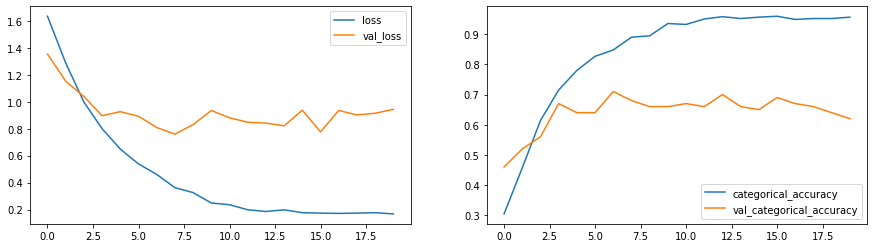

In [35]:
train_model(buildModelCNNRNN3,num_of_frames=10,img_size=100,batch_size=10,num_epoch=20,initial_lr=0.01,saveCheckPoint=True)

In [37]:
def buildModelCNNRNN4(total_frames,img_size):
    model = Sequential()
    mobilenet = MobileNet(include_top=False,weights='imagenet',input_shape=(img_size,img_size,3))
    model.add(TimeDistributed(mobilenet,input_shape=(total_frames,img_size,img_size,3)))
    
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(GRU(128))
    model.add(Dropout(0.3))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(5,activation='softmax'))
    return model

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_24 (TimeDis (None, 10, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_25 (TimeDis (None, 10, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_26 (TimeDis (None, 10, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_27 (TimeDis (None, 10, 1024)          0         
_________________________________________________________________
gru_6 (GRU)                  (None, 128)               443136    
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 128)             

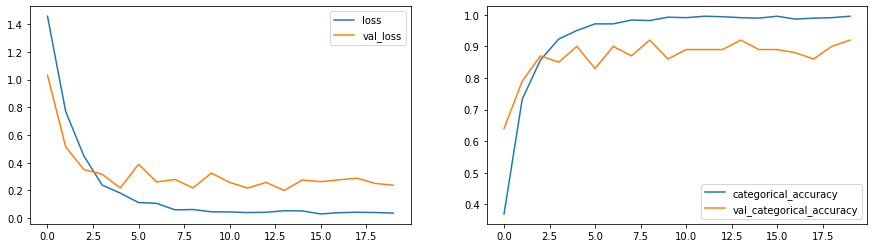

In [38]:
train_model(buildModelCNNRNN4,num_of_frames=10,img_size=100,batch_size=10,num_epoch=20,initial_lr=0.01,saveCheckPoint=True)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_28 (TimeDis (None, 10, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_29 (TimeDis (None, 10, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_30 (TimeDis (None, 10, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_31 (TimeDis (None, 10, 1024)          0         
_________________________________________________________________
gru_7 (GRU)                  (None, 128)               443136    
_________________________________________________________________
dropout_26 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 128)             

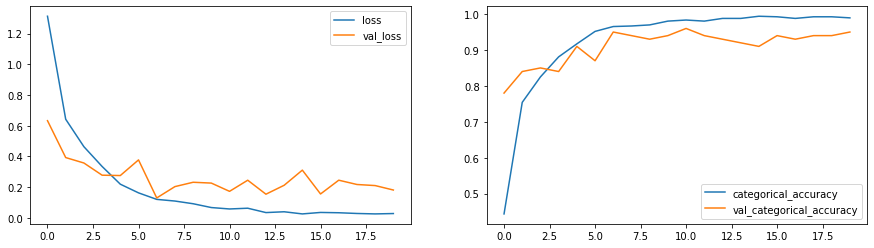

In [39]:
# Reduce the batch size check if model generalises further
train_model(buildModelCNNRNN4,num_of_frames=10,img_size=100,batch_size=5,num_epoch=20,initial_lr=0.01,saveCheckPoint=True)